Besides the fact most of the plots refuse to show up inline, all of this code works.  And I've made the eco_functions so that they will work completely separately from the mock plotting functions.  As far as in the fully functioning code, I don't think that's necessary... Well, it will just overplot the titles a lot, I believe. I suppose I could add some conditional statements.  So they won't plot the titles or initialize anything unless they are the only ones being plotted.

In [1]:
%matplotlib inline
import astropy.stats
import matplotlib.pyplot as plt 
from matplotlib import ticker
from matplotlib.ticker import FormatStrFormatter
import numpy as np 
import os
import pandas as pd
from scipy import spatial

In [2]:
#! /usr/bin/env python

# Victor Calderon
# June 29, 2016
# Vanderbilt University

from __future__ import print_function, division, absolute_import
__author__     =['Victor Calderon']
__copyright__  =["Copyright 2016 Victor Calderon, Index function"]
__email__      =['victor.calderon@vanderbilt.edu']
__maintainer__ =['Victor Calderon']
import glob
"""
"""
def Index(directory, datatype):
    """
    Indexes the files in a directory `directory' with a
    specific data type.
    
    Parameters
    ----------
    directory: str
                Absolute path to the folder that is indexed.

    datatype: str
              Data type of the files to be indexed in the folder.

    Returns
    -------
    file_array: array_like 
                 num.array of indexed files in the folder 'directory' 
                 with specific datatype.

    Examples
    --------
    >>> Index('~/data', '.txt')
    >>> array(['A.txt', 'Z'.txt', ...])
    """
    assert(os.path.exists(directory))
    files = np.array(glob.glob('{0}/*{1}'.format(directory, datatype)))
    
    return files

In [3]:
def sph_to_cart(ra,dec,cz):
    """
    Converts spherical coordinates to Cartesian coordinates.
    
    Parameters
    ----------
    ra: array-like
        right-ascension of galaxies in degrees
    dec: array-like
        declination of galaxies in degrees
    cz: array-like
        velocity of galaxies in km/s
    
    Returns
    -------
    coords: array-like, shape = N by 3
        x, y, and z coordinates
    """
    cz_dist = cz/70. #converts velocity into distance
    x_arr   = cz_dist*np.cos(np.radians(ra))*np.cos(np.radians(dec))
    y_arr   = cz_dist*np.sin(np.radians(ra))*np.cos(np.radians(dec))
    z_arr   = cz_dist*np.sin(np.radians(dec))
    coords  = np.column_stack((x_arr,y_arr,z_arr))
    
    return coords

In [4]:
def calc_dens(n_val,r_val):
    """
    Returns densities of spheres with radius being the distance to the 
        nth nearest neighbor.
    
    Parameters
    ----------
    n_val = integer
        The 'N' from Nth nearest neighbor
    r_val = array-like
        An array with the distances to the Nth nearest neighbor for
        each galaxy
    
    Returns
    -------
    dens: array-like
        An array with the densities of the spheres created with radii
        to the Nth nearest neighbor.
    """
    dens = np.array([(3.*(n_val+1)/(4.*np.pi*r_val[hh]**3)) \
                     for hh in range(len(r_val))])
    
    return dens

In [5]:
def plot_calcs(mass,mass_err=False,ratio_err=False):
	"""
	Returns values for plotting the stellar mass function and 
		mass ratios
	
	Parameters
	----------
	mass: array-like
		A 1D array with mass values
		
	Returns
	-------
	bin_centers: array-like
		An array with the medians of the mass bins
   
	"""
	bins  = np.linspace(9.2,11.8,14)
	dlogM = 0.2

	mass_counts, edges = np.histogram(mass,bins)
	bin_centers        = 0.5*(edges[:-1]+edges[1:])

	mass_freq  = mass_counts/float(len(mass))/dlogM
	
	ratio_dict = {}
	frac_val   = [2,4,10]
	yerr = []
	
	for ii in frac_val:
		ratio_dict[ii] = {}
		
		# Calculations for the lower density cut
		frac_data      = int(len(mass)/ii)
		frac_mass      = mass[0:frac_data]
		counts, edges  = np.histogram(frac_mass,bins)
		
		# Calculations for the higher density cut
		frac_mass_2       = mass[-frac_data:]
		counts_2, edges_2 = np.histogram(frac_mass_2,bins)
		
		# Ratio determination
		ratio_counts   = (1.*counts_2)/(1.*counts)
		ratio_dict[ii] = ratio_counts

		yerr.append((counts_2*1.)/(counts*1.)*np.sqrt(1./counts + 1./counts_2))
	
	if ratio_err == True:
		ratio_dict_list = [[] for xx in range(2)]
		ratio_dict_list[0] = ratio_dict
		ratio_dict_list[1] = yerr
		ratio_dict = ratio_dict_list
		
	if mass_err == True:
		mass_freq_list    = [[] for xx in xrange(2)]
		mass_freq_list[0] = mass_freq
		mass_freq_list[1] = np.sqrt(mass_counts)/float(len(mass))/dlogM
		
		mass_freq         = np.array(mass_freq_list)
	

	return bin_centers, mass_freq, ratio_dict

In [6]:
def bin_func(mass_dist,kk,bootstrap=False):
	"""
	Returns median distance to Nth nearest neighbor, the x-value at which to 
		plot the median distance, and the distances that correspond
		to the galaxies in each bin.
	
	Parameters
	----------
	mass_dist: array-like
		An array with mass values in at index 0 and distance to the Nth 
		nearest neighbor in the other 6
	kk: integer-like
		The index of mass_dist where the appropriate distance array may be found
		
	Returns
	-------
	medians: array-like
		An array with the median distance to the Nth nearest neighbor for 
		all the galaxies in each of the bins
	"""
	edges       = np.linspace(9.2,11.8,14)
	digitized   = np.digitize(mass_dist.T[0],edges)
	# digitized   = np.digitize(nn_mass_dist[1].T[0],edges)
	digitized  -= int(1)
	
	bin_nums    = np.unique(digitized)
	bin_nums    = list(bin_nums)
	if 12 not in bin_nums:
		bin_nums.append(12)
		bin_nums= np.array(bin_nums)
	# print bin_nums
	medians     = np.array([np.median(mass_dist.T[kk][digitized==ii]) for ii in bin_nums])

	if bootstrap == True:
#         col = np.arange(1,7)
		bin_nums = np.unique(digitized)
#         for kk in col:
		dist_in_bin = np.array([(mass_dist.T[kk][digitized == ii]) \
				for ii in range(1,len(edges))])


		dist_in_bin    = np.array([(mass_dist.T[kk][digitized==ii]) for ii in bin_nums])
		low_err_test   = np.array([np.percentile(astropy.stats.bootstrap\
											 (dist_in_bin[vv],bootnum=1000,\
											  bootfunc=np.median),16) for vv \
									 in range(len(dist_in_bin))])
		high_err_test  = np.array([np.percentile(astropy.stats.bootstrap\
											 (dist_in_bin[vv],bootnum=1000,\
											  bootfunc=np.median),84) for vv \
									 in range(len(dist_in_bin))])
		
		med_list    = [[] for yy in range(3)]
		med_list[0] = medians
		med_list[1] = low_err_test
		med_list[2] = high_err_test
		medians     = np.array(med_list)

	return medians    

In [7]:
def plot_eco_rats(bin_centers,y_vals,neigh_val,ax,col_num,plot_idx,only=False):
    """
    Returns subplots of ECO density-cut,mass ratios
    
    Parameters
    ----------
    bin_centers: array-like
        An array with the medians mass values of the mass bins
    y_vals: array-like
        An array containing the ratio values for each mass bin
    neigh_val: integer-like
        Value which will be inserted into the text label of each plot
    ax: axis-like
        A value which specifies which axis each subplot is to be 
        plotted to
    col_num: integer-like
        Integer which specifies which column is currently being 
        plotted. Used for labelling subplots
    plot_idx: integer-like
        Specifies which subplot the figure is plotted to. Used for
        labeling the x-axis
    
    Optional
    --------
    only == True
        To be used when only plotting the ECO ratios, no mocks.
        Will add in the additional plotting specifications that
        would have been taken care of previously in a for-loop
        which plotted the mocks as well
        
    Returns
    -------
    ECO ratios plotted to any previously initialized figure
    """
    if only == True:
        if plot_idx     ==16:
            ax.set_xlabel('$\log\ M_{*}$',fontsize=18)
        if col_num      ==0:
            title_label = 'Mass Ratio 50/50, {0} NN'.format(neigh_val)
            frac_val    = 10
            ax.text(0.05, 0.95, title_label,horizontalalignment='left',\
                    verticalalignment='top',transform=ax.transAxes,fontsize=12)
        elif col_num    ==1:
            title_label = 'Mass Ratio 25/75, {0} NN'.format(neigh_val)
            frac_val    = 4
            ax.text(0.05, 0.95, title_label,horizontalalignment='left',\
                    verticalalignment='top',transform=ax.transAxes,fontsize=12)
        elif col_num    ==2:
            title_label = 'Mass Ratio 10/90, {0} NN'.format(neigh_val)
            frac_val    = 2
            ax.text(0.05, 0.95, title_label,horizontalalignment='left',\
                    verticalalignment='top',transform=ax.transAxes,fontsize=12)
        ax.set_xlim(9.2,11.8)
        ax.set_ylim([0,5])
        ax.set_xticks(np.arange(9.5, 12., 0.5))
        ax.set_yticks([1.,3.])
        ax.tick_params(axis='both', labelsize=12)
        ax.axhline(y=1,c="darkorchid",linewidth=0.5,zorder=0)
    frac_vals = np.array([2,4,10])
    y_vals_2 = y_vals[0][frac_vals[hh]]
    ax.errorbar(bin_centers,y_vals_2,yerr=y_vals[1][hh],\
                color='limegreen',linewidth=2)
#for some reason, whenever I give this frac_vals as an argument, it won't recognize it as an array. 
#And then it will begin with 10, rather than 2; even when I have it tell me what frac val it's using, 
#and then have the for loop do so as well, they do not line up
#also, it plots only ECO differently than when there are multiple curves, and it changes 
#the xlims. So I set them. And then, it made the 17th indexed plot slightly off, so I changed the xticks
#as well

In [8]:
def plot_eco_meds(bin_centers,y_vals,low_lim,up_lim,neigh_val,ax,plot_idx):
    titles = [1,2,3,5,10,20]
    ax.set_ylim(0,10**1.5)
    ax.set_xlim(9.2,11.8)
    ax.set_yscale('symlog')
    ax.set_xticks(np.arange(9.5,12.,0.5))  
    ax.tick_params(axis='both', which='major', labelsize=16)
    title_here = 'n = {0}'.format(titles[plot_idx])
    ax.text(0.05, 0.95, title_here,horizontalalignment='left',\
            verticalalignment='top',transform=ax.transAxes,fontsize=18)
    ax.errorbar(bin_centers,y_vals,yerr=0.1,lolims=low_lim[neigh_val],\
        uplims=up_lim[neigh_val],color='deeppink')

In [9]:
#assumed variables
neigh_vals = np.array([1,2,3,5,10,20])

In [10]:
eco_path = r"C:\Users\Hannah\Desktop\Vanderbilt_REU\Stellar_mass_env_density\Catalogs\ECO_true"
ECO_true = (Index(eco_path,'.txt'))
names    = ['ra','dec','cz','logMstar']
PD_eco   = pd.read_csv(ECO_true[0],sep="\s+", usecols=(0,1,2,4),header=None,\
				   skiprows=1,names=names)
eco_comp = PD_eco[PD_eco.logMstar >= 9.3]

ra_eco   = (np.array(eco_comp)).T[0]
dec_eco  = (np.array(eco_comp)).T[1] 
cz_eco   = (np.array(eco_comp)).T[2] 
mass_eco = (np.array(eco_comp)).T[3]

coords_eco        = sph_to_cart(ra_eco,dec_eco,cz_eco)
eco_neighbor_tree = spatial.cKDTree(coords_eco)
eco_tree_dist     = np.array(eco_neighbor_tree.query(coords_eco,21)[0])
eco_mass_dist = np.column_stack((mass_eco,eco_tree_dist.T[neigh_vals].T))
eco_dens = ([calc_dens(neigh_vals[jj],\
						(eco_mass_dist.T[range(1,7)[jj]])) for jj in range(len(neigh_vals))])
eco_mass_dens = [(np.column_stack((mass_eco,eco_dens[ii]))) for ii in range(len(neigh_vals))]
eco_idx  = [(eco_mass_dens[jj].T[1].argsort()) for jj in range(len(neigh_vals))]
eco_mass_dat  = [(eco_mass_dens[jj][eco_idx[jj]].T[0]) for jj in range(len(neigh_vals))]
eco_ratio_info    = [[] for xx in xrange(len(eco_mass_dat))]

for qq in range(len(eco_mass_dat)):
    bin_centers, eco_freq, eco_ratio_info[qq] = plot_calcs(eco_mass_dat[qq],mass_err=True,ratio_err=True)

eco_medians = [[] for xx in xrange(len(eco_mass_dat))]    
for jj in (range(len(eco_mass_dat))):
    eco_medians[jj] = np.array(bin_func(eco_mass_dist,(jj+1),bootstrap=True))

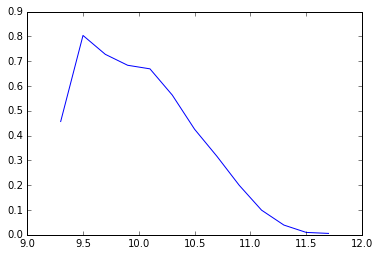

In [11]:
plt.plot(bin_centers,eco_freq[0])
plt.show()

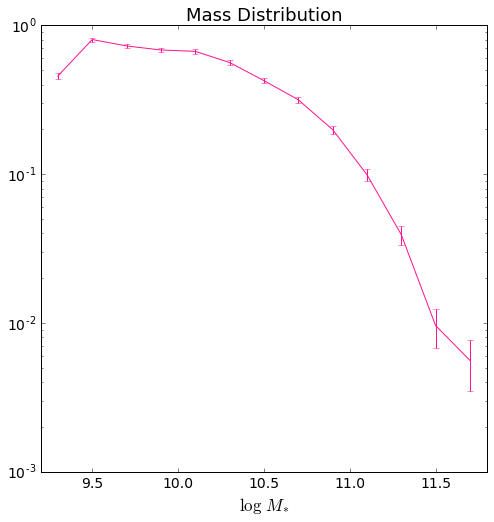

In [12]:
###stellar mass function

fig,ax = plt.subplots(figsize=(8,8))
ax.set_title('Mass Distribution',fontsize=18)
ax.set_xlabel('$\log\ M_{*}$',fontsize=17)
ax.set_yscale('log')
ax.set_xlim(9.2,11.8)
ax.tick_params(axis='both', labelsize=14)
ax.errorbar(bin_centers,eco_freq[0],yerr=eco_freq[1],color='deeppink')
plt.show()

In [13]:
%matplotlib qt
np.seterr(divide='ignore',invalid='ignore')
frac_vals = [2,4,10]
nrow_num = int(6)
ncol_num = int(3)
zz       = int(0)

fig, axes = plt.subplots(nrows=nrow_num, ncols=ncol_num, \
            figsize=(100,200), sharex= True,sharey=True)
axes_flat = axes.flatten()
# fig.suptitle("Percentile Trends", fontsize=18)

while zz <= 16:
    for ii in range(len(eco_ratio_info)):
        for hh in range(len(eco_ratio_info[0][1])):
            plot_eco_rats(bin_centers,(eco_ratio_info[ii]),neigh_vals[ii],axes_flat[zz],hh,zz,only=True)
            zz += 1

plt.subplots_adjust(left=0.02, bottom=0.09, right=1.00, top=1.00,\
                    hspace=0,wspace=0)

plt.show()    

In [14]:
print (range(len(eco_ratio_info)))

[0, 1, 2, 3, 4, 5]


In [15]:
%matplotlib qt
nrow_num_mass = 2
ncol_num_mass = 3
zz = int(0)

fig, axes = plt.subplots(nrows=nrow_num_mass, ncols=ncol_num_mass, \
						 figsize=(100,200), sharex= True, sharey = True)
axes_flat = axes.flatten()

zz = int(0)
while zz <=4:
	for ii in range(len(eco_medians)):
		plot_eco_meds(bin_centers,eco_medians[ii][0],\
                eco_medians[ii][1],eco_medians[ii][2],ii,axes_flat[zz],zz)
		zz += 1
        
plt.subplots_adjust(left=0.05, bottom=0.09, right=1.00, top=1.00,\
					hspace=0,wspace=0)
plt.show()